In [1]:
import polars as pl # similar pandas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import pyarrow.parquet as pq
import pyarrow as pa
from pandas.api.types import CategoricalDtype
import plotly.express as px
import folium
from folium.plugins import MarkerCluster
from folium.plugins import HeatMap

# 1. LOAD DATA
## Load CSV/Parquet files into Polars DataFrames
#### If Parquet exists, read it directly; otherwise read CSV, write Parquet, then read

In [2]:
# Paths
csv_dir = Path("../../data/csv")
parquet_dir = Path("../../data/parquet")
parquet_dir.mkdir(exist_ok=True)

tables = ["flights_sample_3m", 
         "airports_clean"]

dfs = {}

for table in tables:
    csv_path = csv_dir / f"{table}.csv"
    parquet_path = parquet_dir / f"{table}.parquet"

    try:
        if parquet_path.exists(): 
            print(f"{parquet_path} already exists, reading Parquet...")
        else:
            print(f"{parquet_path} not found, reading CSV and writing Parquet...")
            (pl.scan_csv(csv_path, low_memory=True).sink_parquet(parquet_path))
            print(f"{parquet_path} has been created.\n")

        # Read parquet
        df = pl.read_parquet(parquet_path)
        dfs[table] = df
        print(f"{table}: {df.shape[0]} rows, {df.shape[1]} columns\n")

    except Exception as e:
        print(f"Error reading {table}: {e}")

..\..\data\parquet\flights_sample_3m.parquet already exists, reading Parquet...
flights_sample_3m: 3000000 rows, 32 columns

..\..\data\parquet\airports_clean.parquet already exists, reading Parquet...
airports_clean: 7697 rows, 6 columns



In [3]:
df_flights = dfs["flights_sample_3m"]
df_airports = dfs["airports_clean"]

# 2. FEATURE ENGINEERING & DATA CLEANING
## 2.1 Feature Engineering
### Time & Distance Features

In [27]:
dow_category = CategoricalDtype(categories=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday",
                                            "Saturday", "Sunday"], ordered=True)

dow_map = {1: "Monday", 2: "Tuesday", 3: "Wednesday", 4: "Thursday",
           5: "Friday", 6: "Saturday", 7: "Sunday"}

def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

if df_flights.schema["FL_DATE"] == pl.Utf8:
    df_flights = df_flights.with_columns(
        pl.col("FL_DATE").str.strptime(pl.Date)
    )
    
df_flights = df_flights.with_columns([
    pl.col("FL_DATE").dt.year().alias("YEAR"),
    pl.col("FL_DATE").dt.month().alias("MONTH"),
    (((pl.col("FL_DATE").dt.month() - 1) // 3) + 1).alias("QUARTER"),
    pl.col("FL_DATE").dt.weekday().alias("DAY_OF_WEEK"),
    pl.col("FL_DATE").dt.month().map_elements(get_season).alias("SEASON"),
    # Bọc string bằng pl.lit() để pl hiểu là giá trị, ko phải tên cột
    pl.when(pl.col("DISTANCE") <= 500).then(pl.lit("Short-haul"))
      .when(pl.col("DISTANCE") <= 1500).then(pl.lit("Medium-haul"))
      .otherwise(pl.lit("Long-haul"))
      .alias("DISTANCE_CAT")
])

### Adding Geolocation Columns

In [5]:
airports_ll = (
    df_airports
    .filter(pl.col("IATA").is_not_null() & (pl.col("IATA") != ""))
    .select(["IATA", "LAT", "LON"])
)

df_flights = (
    df_flights.join(airports_ll, left_on="ORIGIN", right_on="IATA", how="left").
    rename({"LAT": "ORIGIN_LAT", "LON": "ORIGIN_LON"}).
        join(airports_ll, left_on="DEST", right_on="IATA", how="left").
        rename({"LAT": "DEST_LAT", "LON": "DEST_LON"})
)

## 2.2 Check for missing values

In [6]:
def check_missing_cols(df):
    missing_cols = []
    no_missing_cols = []

    for col in df.columns:
        missing_count = df[col].null_count()
        if missing_count > 0:
            missing_cols.append((col, missing_count))
        else:
            no_missing_cols.append(col)

    print("Columns WITH missing values:")
    if missing_cols:
        for col, cnt in missing_cols:
            print(f"- {col}: {cnt}")
    else:
        print("None")

    print("\nColumns WITHOUT missing values:")
    print(no_missing_cols if no_missing_cols else "None")

check_missing_cols(df_flights)

Columns WITH missing values:
- DEP_TIME: 77615
- DEP_DELAY: 77644
- TAXI_OUT: 78806
- WHEELS_OFF: 78806
- WHEELS_ON: 79944
- TAXI_IN: 79944
- ARR_TIME: 79942
- ARR_DELAY: 86198
- CANCELLATION_CODE: 2920860
- CRS_ELAPSED_TIME: 14
- ELAPSED_TIME: 86198
- AIR_TIME: 86198
- DELAY_DUE_CARRIER: 2466137
- DELAY_DUE_WEATHER: 2466137
- DELAY_DUE_NAS: 2466137
- DELAY_DUE_SECURITY: 2466137
- DELAY_DUE_LATE_AIRCRAFT: 2466137
- ORIGIN_LAT: 735
- ORIGIN_LON: 735
- DEST_LAT: 762
- DEST_LON: 762

Columns WITHOUT missing values:
['FL_DATE', 'AIRLINE', 'AIRLINE_DOT', 'AIRLINE_CODE', 'DOT_CODE', 'FL_NUMBER', 'ORIGIN', 'ORIGIN_CITY', 'DEST', 'DEST_CITY', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'CANCELLED', 'DIVERTED', 'DISTANCE', 'YEAR', 'MONTH', 'QUARTER', 'DAY_OF_WEEK', 'SEASON', 'DISTANCE_CAT']


## 2.3 Format numbers

In [7]:
def format_compact(n):
    if n >= 1_000_000:
        x = n / 1_000_000
        return f"{x:.1f}M".replace(".0M", "M")
    if n >= 1_000:
        x = n / 1_000
        return f"{x:.1f}K".replace(".0K", "K")
    return str(n)

# 3. EDA
## 3.1 Homepage
### Summary

In [8]:
def pct_vs_baseline(df, year, baseline):
    n_year = df.filter(pl.col("YEAR") == year)["n_flights"][0]
    n_base = df.filter(pl.col("YEAR") == baseline)["n_flights"][0]
    return round(((n_year - n_base)/n_base) * 100, 2)

In [17]:
flight_yearly = (
    df_flights.group_by("YEAR")
        .agg(pl.len().alias("n_flights")).sort("YEAR")
)

df_cancel = (
    df_flights.filter(pl.col("CANCELLED") == 1).group_by("YEAR")
        .agg(pl.len().alias("n_flights")).sort("YEAR")
)

df_delay = (
    df_flights.filter(pl.col("DEP_DELAY") > 15).group_by("YEAR")
        .agg(pl.len().alias("n_flights")).sort("YEAR")
)

df_ontime = (
    df_flights.filter(pl.col("DEP_DELAY") <= 15).group_by("YEAR")
        .agg(pl.len().alias("n_flights")).sort("YEAR")
)

df_divert = (
    df_flights.filter(pl.col("DIVERTED") == 1).group_by("YEAR")
        .agg(pl.len().alias("n_flights")).sort("YEAR")
)

In [18]:
pct_23_19_flight = pct_vs_baseline(flight_yearly, 2023, 2019)
pct_23_19_cancel = pct_vs_baseline(df_cancel, 2023, 2019)
pct_23_19_delay = pct_vs_baseline(df_delay, 2023, 2019)
pct_23_19_ontime = pct_vs_baseline(df_ontime, 2023, 2019)
pct_23_19_divert = pct_vs_baseline(df_divert, 2023, 2019)

#-----------------------------
total_flights = df_flights.height
total_flights_fmt = format_compact(total_flights)

total_airlines = df_flights["AIRLINE"].n_unique()
total_airports = df_flights["ORIGIN"].n_unique()

total_routes = df_flights.select(["ORIGIN", "DEST"]).unique().height

In [19]:
print(f"U.S. Flight Operations: 2019–2023"
      f"\nFlights volume: {pct_23_19_flight}%"
      f"\nCancelled: {pct_23_19_cancel}%"
      f"\nDelays: {pct_23_19_delay}%"
      f"\nDiverted: {pct_23_19_divert}%"
      f"\nOn-time: {pct_23_19_ontime}%"
      f"\ntotal_flights: {total_flights_fmt}"
      f"\ntotal_airlines: {total_airlines}"
      f"\ntotal_airports: {total_airports}"
      f"\ntotal_routes: {total_routes}"
)

U.S. Flight Operations: 2019–2023
Flights volume: -38.83%
Cancelled: -42.56%
Delays: -25.01%
Diverted: -36.41%
On-time: -41.79%
total_flights: 3M
total_airlines: 18
total_airports: 380
total_routes: 7785


### Chart: Weekly Distribution

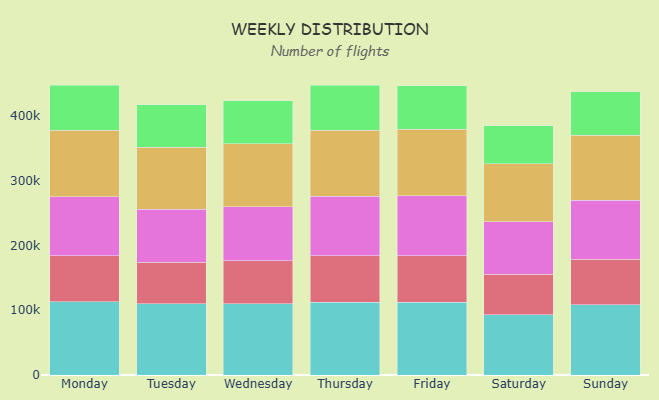

In [176]:
df_dow = (
    df_flights
    .group_by(["YEAR", "DAY_OF_WEEK"])
    .agg(pl.len().alias("n_flights"))
    .with_columns(
        # convert DAY_OF_WEEK (1–7) → Monday–Sunday
        pl.col("DAY_OF_WEEK")
        .map_elements(lambda x: dow_map.get(x), return_dtype=pl.Utf8)
        .alias("DAY"),

        # YEAR → string (Plotly views as categorical)
        pl.col("YEAR").cast(pl.Utf8)
    )
    .sort(["YEAR", "DAY_OF_WEEK"])
)

year_colors = {
    "2019": "#47c6d1", 
    "2020": "#de506f",  
    "2021": "#e657e3", 
    "2022": "#deab4e", 
    "2023": "#4df06b",
}
fig = px.bar(df_dow,
            x='DAY', y='n_flights',
            color='YEAR', color_discrete_map = year_colors,
            height=400, 
            color_discrete_sequence = px.colors.qualitative.Pastel)
fig.update_layout(barmode="stack", showlegend = False,
                  xaxis_title = None, yaxis_title = None,
                  yaxis=dict(showgrid=False),
                  title=dict(
                    text=(
                        "WEEKLY DISTRIBUTION"
                        "<br><span style='font-size:14px;color:#666;font-style:italic'>Number of flights</span>"
                    ),
                    x=0.5,
                    xanchor="center"
                  ),
                  margin = dict(l=10, r=10, t=70, b=10),
                  paper_bgcolor="#e3f0b9",   # nền toàn figure (kể cả title)
                  plot_bgcolor="#e3f0b9",    # nền vùng bar chart
                  title_font=dict(size=16, color="#333", family="Comic Sans MS")
)
fig.update_traces(opacity = 0.8)
fig.show()

### Chart: Airline Rankings

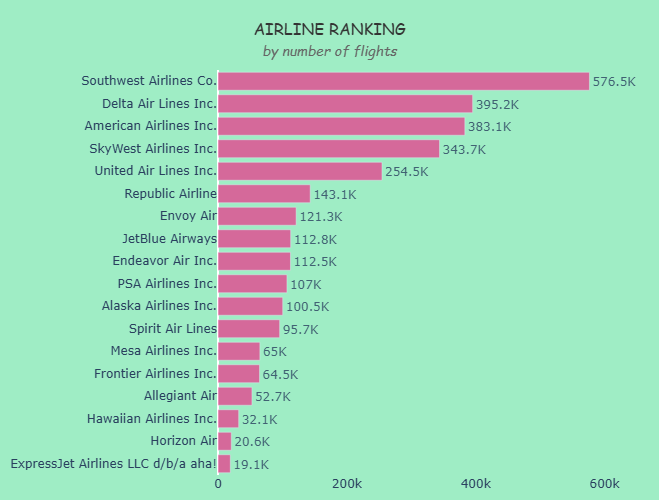

In [183]:
df_air_rank = (
    df_flights
    .group_by("AIRLINE")
    .agg(pl.len().alias("n_flights"))
    .sort("n_flights", descending=True)
).to_pandas()

df_air_rank["text"] = df_air_rank["n_flights"].apply(format_compact)

fig = px.bar(
    df_air_rank,
    x="n_flights", y="AIRLINE",
    orientation="h", text="text", 
    color_discrete_sequence=["#e34990"]  # màu tất cả bar
)
fig.update_layout(yaxis_title = None, xaxis_title=None,
                  yaxis=dict(autorange="reversed"), 
                  xaxis=dict(showgrid=False),                 
                  height = 500,
                  title=dict(
                    text=(
                        "AIRLINE RANKING"
                        "<br><span style='font-size:14px;color:#666;font-style:italic'>by number of flights</span>"
                    ),
                    x=0.5,
                    xanchor="center"
                  ),
                  margin = dict(l=200, r=50, t=70, b=10),
                  paper_bgcolor="#9fedc5",   # nền toàn figure (kể cả title)
                  plot_bgcolor="#9fedc5",    # nền vùng bar chart
                  title_font=dict(size=16, color="#333", family="Comic Sans MS")
)
# Hiển thị text bên ngoài bar, cliponaxis để text xuất hiện đầy đủ
fig.update_traces(textposition='outside', cliponaxis=False,
                 opacity = 0.8)
fig.show()

### Chart: Monthly Departures

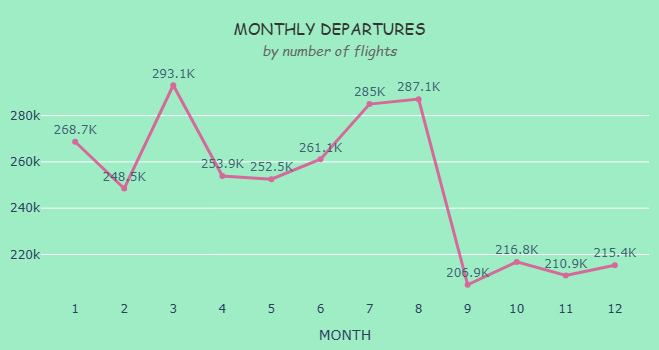

In [181]:
df_monthly_departures = (
    df_flights
    .group_by("MONTH")
    .agg(pl.len().alias("n_flights"))
    .sort("MONTH")
).to_pandas()

df_monthly_departures["text"] = df_monthly_departures["n_flights"].apply(format_compact)

fig = px.line(df_monthly_departures,
              x='MONTH', y='n_flights',
              markers=True, text="text")
fig.update_layout(yaxis_title = None,  
                  xaxis=dict(showgrid=False), 
                  height = 350,
                  title=dict(
                    text=(
                        "MONTHLY DEPARTURES"
                        "<br><span style='font-size:14px;color:#666;font-style:italic'>by number of flights</span>"
                    ),
                    x=0.5,
                    xanchor="center"
                  ),
                  margin = dict(l=10, r=10, t=70, b=10),
                  paper_bgcolor="#9fedc5",   # nền toàn figure (kể cả title)
                  plot_bgcolor="#9fedc5",    # nền vùng bar chart
                  title_font=dict(size=16, color="#333", family="Comic Sans MS")
)
fig.update_xaxes(type="category") # để trục x chỉ show 1 2 3 4
# Hiển thị text ra ngoài điểm marker
fig.update_traces(
    textposition='top center',  # hoặc 'bottom center', 'middle right', 'middle left'
    opacity = 0.8, cliponaxis=False, # cliponaxis để text xuất hiện đầy đủ
    line=dict(color="#e34990", width=3),
)
fig.show()

### Chart: Flight Distance Distribution

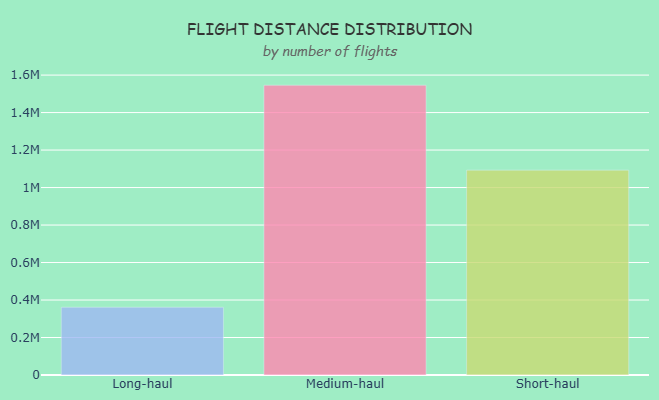

In [171]:
df_distance_departures = (
    df_flights
    .group_by("DISTANCE_CAT")
    .agg(pl.len().alias("n_flights")).sort("DISTANCE_CAT")
)

fig = px.bar(df_distance_departures,
            x='DISTANCE_CAT', y='n_flights',
            color='DISTANCE_CAT', color_discrete_map = year_colors,
            height=400, 
            color_discrete_sequence = px.colors.qualitative.Pastel)
fig.update_layout(showlegend = False,
                  xaxis_title = None, yaxis_title = None,
                  title=dict(
                    text=(
                        "FLIGHT DISTANCE DISTRIBUTION"
                        "<br><span style='font-size:14px;color:#666;font-style:italic'>by number of flights</span>"
                    ),
                    x=0.5,
                    xanchor="center"
                  ),
                  margin = dict(l=10, r=10, t=70, b=10),
                  paper_bgcolor="#9fedc5",   # nền toàn figure (kể cả title)
                  plot_bgcolor="#9fedc5",    # nền vùng bar chart
                  title_font=dict(size=16, color="#333", family="Comic Sans MS")
)
fig.update_traces(opacity = 0.8)
fig.show()